In [146]:
import os
import sys
import json
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape

dataset_path = r"C:\Users\lhauptmann\Code\WristPPG2\data\dataset"

In [271]:
def center_signal(signal, start_idx, end_idx):

    window_signal = signal[start_idx:end_idx]
    centroid = (window_signal * np.arange(len(window_signal))).sum() / window_signal.sum()
    shift = centroid - len(window_signal) / 2
    
    return shift
    
    

In [278]:
def import_hdf5_session(file_path, fixed_length:int=None):
    samples = []
    with h5py.File(file_path, 'r') as f:
        data_dict = f["data"]
        
        acc_mag = np.sqrt(data_dict["acc_x"][:]**2 + data_dict["acc_y"][:]**2 + data_dict["acc_z"][:]**2)
        acc_mag_abs = np.abs((acc_mag - np.mean(acc_mag)) / np.std(acc_mag))
        for key in f.keys():
            if key != "data":
                start_index = f[key]["start_index"][()]
                end_index = f[key]["end_index"][()]
                if start_index == end_index:
                    continue
                shift = int(center_signal(acc_mag_abs, start_index, end_index))
                shift = min(max(shift, -start_index), len(acc_mag_abs) - end_index)
                start_index += shift
                end_index += shift
                
                sample = {}
                
                
                
                for modality in data_dict.keys():
                    sample[modality] = data_dict[modality][start_index:end_index]
                    #sample[modality] = (sample[modality] - np.mean(sample[modality])) / np.std(sample[modality])
                    if fixed_length and end_index - start_index < fixed_length:
                        pad_start = (fixed_length - (end_index - start_index)) // 2
                        pad_end = fixed_length - (end_index - start_index) - pad_start
                        sample[modality] = np.pad(sample[modality], (pad_start, pad_end), "constant")
                    elif fixed_length and end_index - start_index > fixed_length:
                        cut_start = (end_index - start_index - fixed_length) // 2
                        cut_end = end_index - start_index - fixed_length - cut_start
                        sample[modality] = sample[modality][cut_start:-cut_end]
                        
                    
                    
                sample["participant"] = os.path.basename(file_path).split("_")[1]
                sample["session"] = os.path.basename(file_path).split("_")[2].replace(".hdf5", "")
                sample["label"] = key.split("_")[0]
                
                samples.append(sample)
    return samples
                
all_participants = [el for el in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, el))]  
all_files = []
for participant in all_participants:
    participant_path = os.path.join(dataset_path, participant)
    if "exp" in participant or "ppg" in participant:
        continue
    
    all_files += [os.path.join(participant_path, file) for file in os.listdir(participant_path)]       
    



In [279]:
def signal_energy(signal):
    return np.sum(signal ** 2)

def signal_mean(signal):
    return np.mean(signal)

def signal_std(signal):
    return np.std(signal)

def centeredness(signal):
    signal_normalized = np.abs((signal - signal.mean()) / signal.std())
    centroid = (signal_normalized * np.arange(len(signal_normalized))).sum() / signal_normalized.sum()
    return centroid - len(signal_normalized) / 2


def compute_magnitudes(samples):
    if "acc_x" in samples[0].keys() and "acc_y" in samples[0].keys() and "acc_z" in samples[0].keys():
        for sample in samples:
            sample["acc"] = np.sqrt(sample["acc_x"] ** 2 + sample["acc_y"] ** 2 + sample["acc_z"] ** 2)
    
    if "gyro_x" in samples[0].keys() and "gyro_y" in samples[0].keys() and "gyro_z" in samples[0].keys():
        for sample in samples:
            sample["gyro"] = np.sqrt(sample["gyro_x"] ** 2 + sample["gyro_y"] ** 2 + sample["gyro_z"] ** 2)
        
    if "acc_ppg_x" in samples[0].keys() and "acc_ppg_y" in samples[0].keys() and "acc_ppg_z" in samples[0].keys():
        for sample in samples:
            sample["acc_ppg"] = np.sqrt(sample["acc_ppg_x"] ** 2 + sample["acc_ppg_y"] ** 2 + sample["acc_ppg_z"] ** 2)
        
    return samples


def compute_derivitatives(samples):
    for sample in samples:
        keys = list(sample.keys())
        for key in keys:
            if key in ["acc", "gyro", "acc_ppg"]:
                sample[key + "_diff"] = np.diff(sample[key])
    return samples

metrics = {
    "energy": signal_energy,
    "mean": signal_mean,
    "std": signal_std,
    "centeredness": centeredness
}

In [280]:
sample_dict = defaultdict(list)

samples = []

for file in all_files:

    sample = import_hdf5_session(file, fixed_length=None)
    sample = compute_magnitudes(sample)
    sample = compute_derivitatives(sample)
    samples += sample

for i, sample in enumerate(samples):
    
    sample_dict["participant"].append(sample["participant"])
    sample_dict["session"].append(sample["session"])
    sample_dict["label"].append(sample["label"])
    for modality in sample.keys():
        if modality in ["participant", "session", "label", "timestamp", "package_id"] or "ppg_amb" in modality:
            continue
        for metric_name, metric in metrics.items():
            sample_dict[f"{modality}_{metric_name}"].append(metric(sample[modality]))
    sample_dict["id"].append(i)
sample_df = pd.DataFrame(sample_dict)

sample_df["label_id"] = sample_df["label"].astype("category").cat.codes
sample_df["participant_id"] = sample_df["participant"].astype("category").cat.codes

<Axes: >

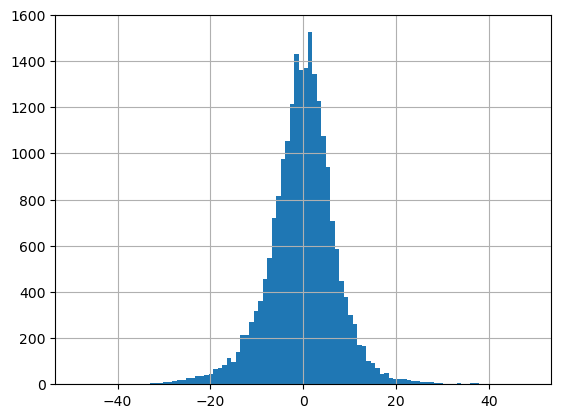

In [281]:
sample_df["acc_centeredness"].hist(bins=100)

<Axes: >

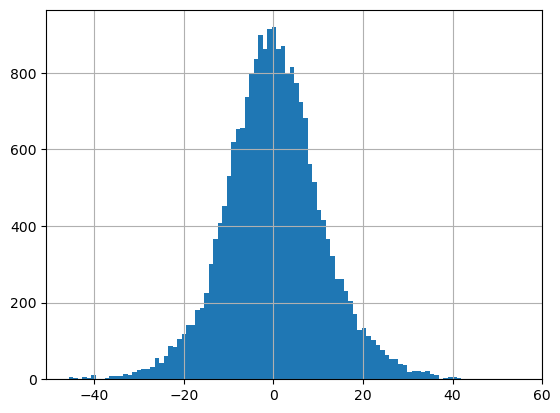

In [261]:
sample_df["acc_centeredness"].hist(bins=100)

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_16892\3825179261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_samples["acc_centeredness_abs"] = filtered_samples["acc_centeredness"].abs()


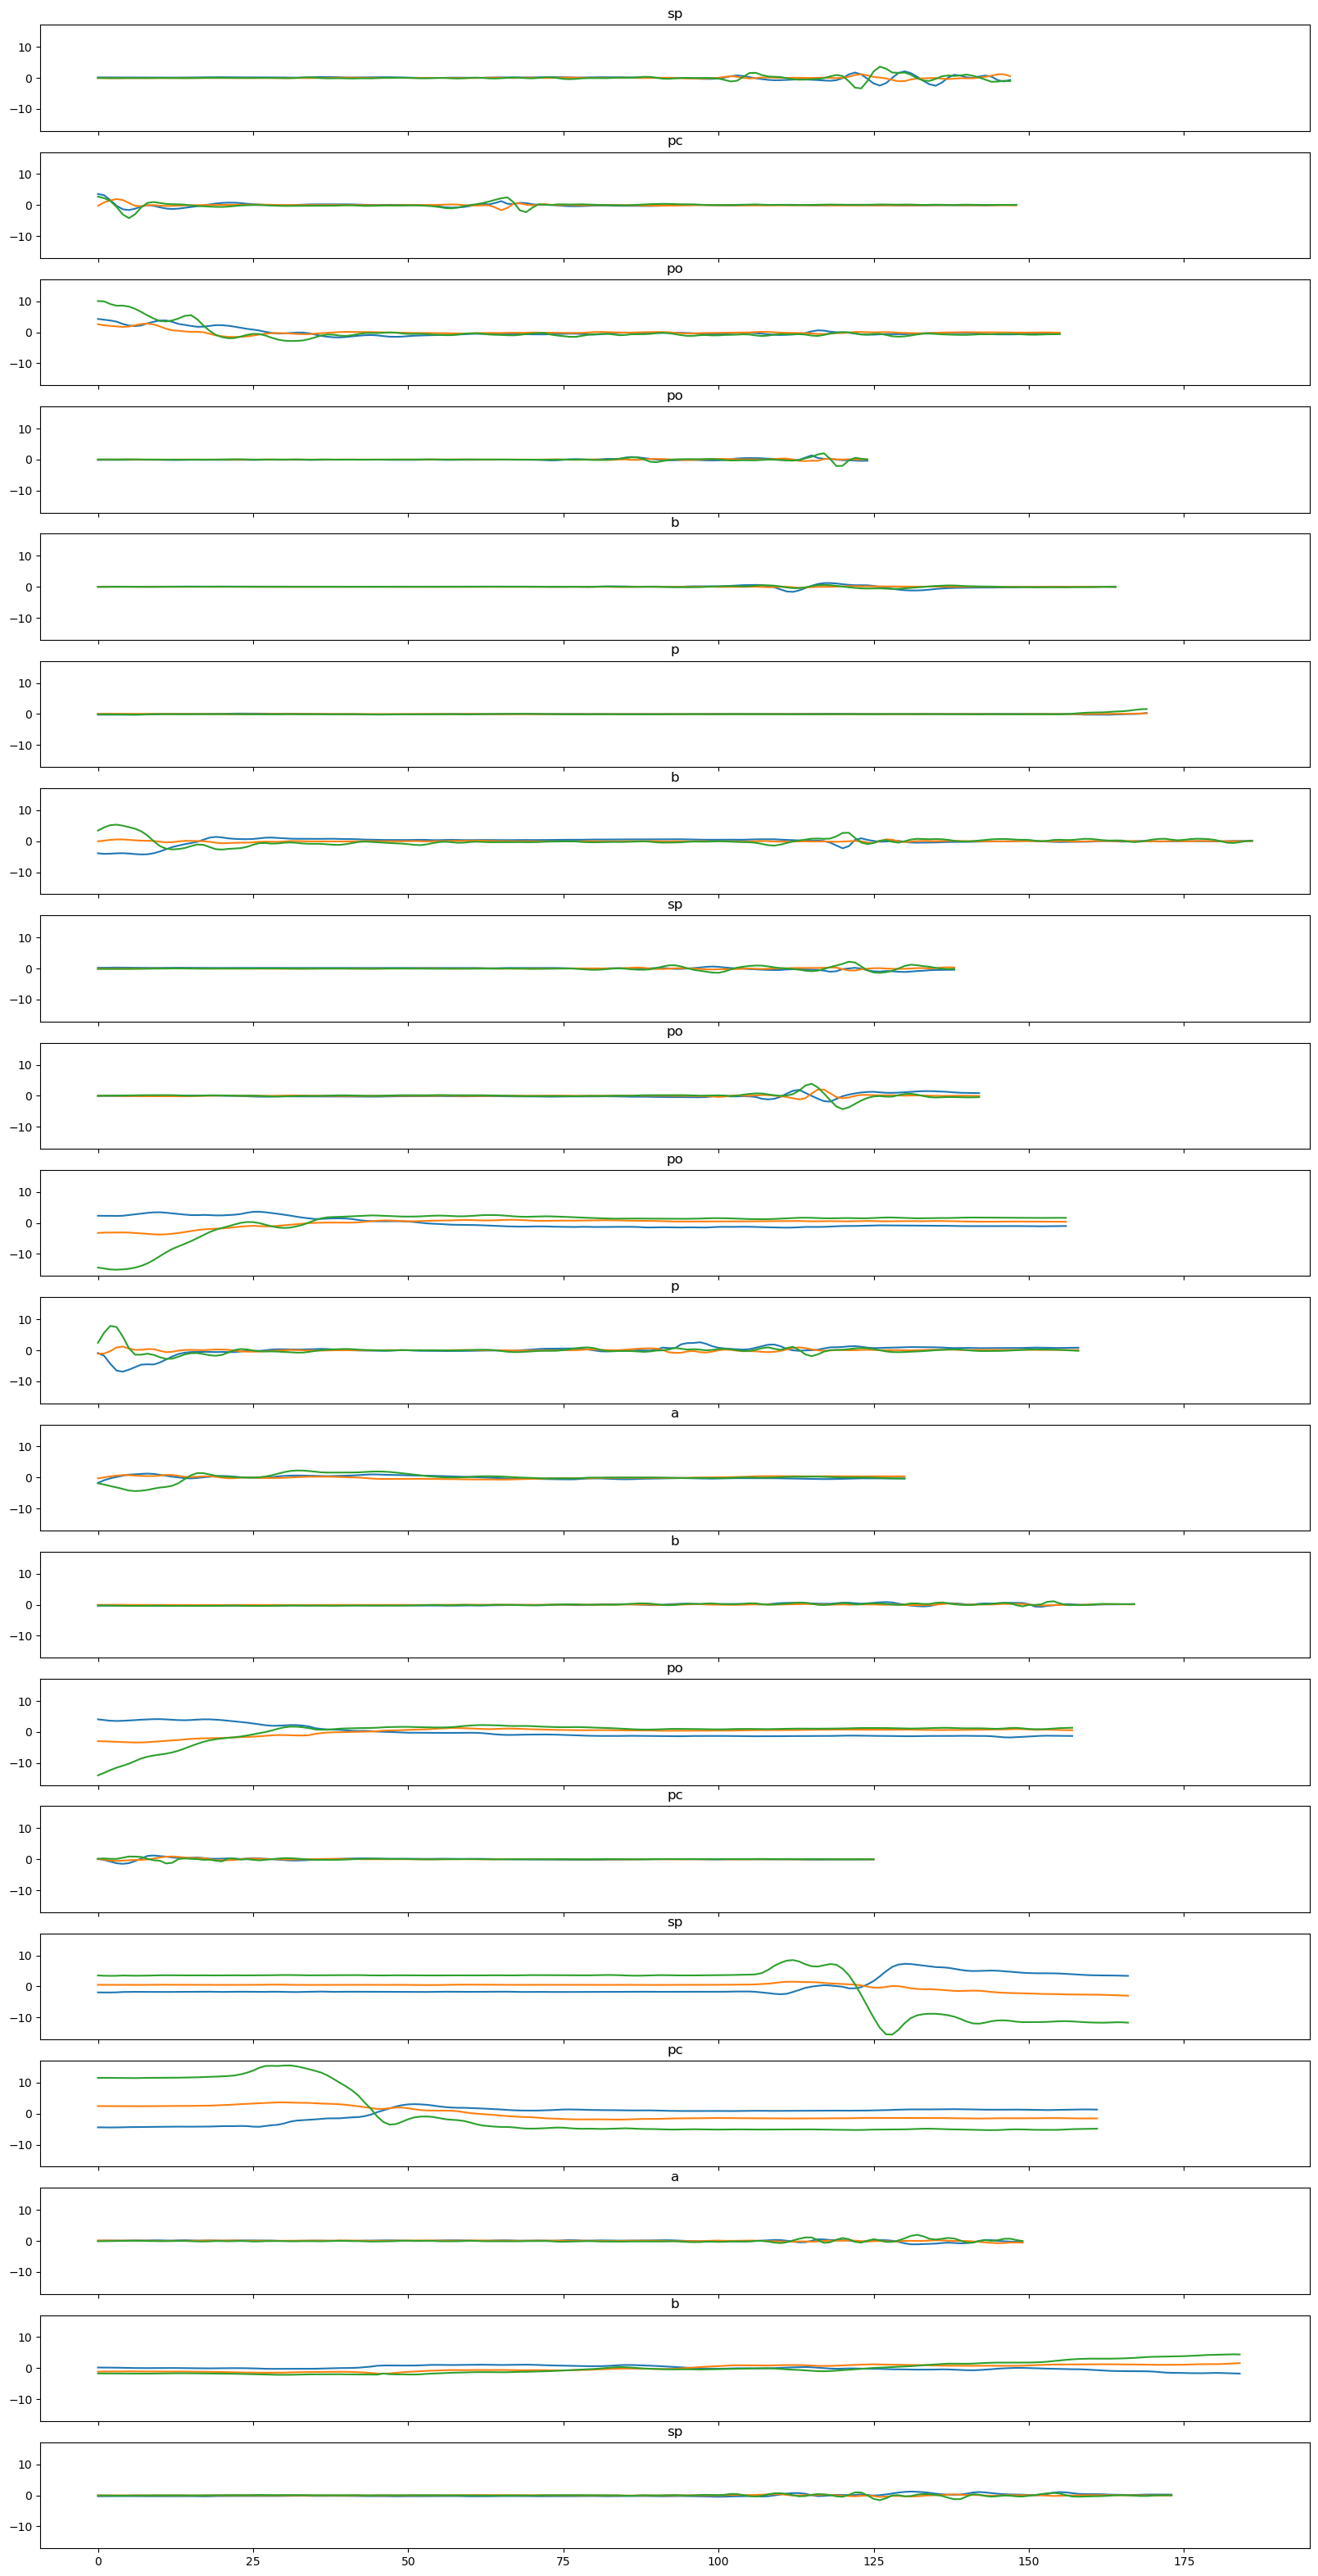

In [283]:
filtered_samples = sample_df[(~sample_df["label"].isin(["o", "pbd", "prr", "prl"]))]
filtered_samples["acc_centeredness_abs"] = filtered_samples["acc_centeredness"].abs()
ids = filtered_samples.sort_values("acc_centeredness_abs", ascending=False).head(20)["id"]




fig, axes = plt.subplots(len(ids), 1, figsize=(20, 2*len(ids)), sharex=True, sharey=True)
for i, id_ in enumerate(ids):
    sample = samples[id_]
    axes[i].plot(sample["acc_z"] - sample["acc_z"].mean())
    axes[i].plot(sample["acc_x"] - sample["acc_x"].mean())
    axes[i].plot(sample["acc_y"] - sample["acc_y"].mean())
    sample
    axes[i].set_title(sample["label"])

<Axes: xlabel='acc_centeredness_abs', ylabel='acc_std'>

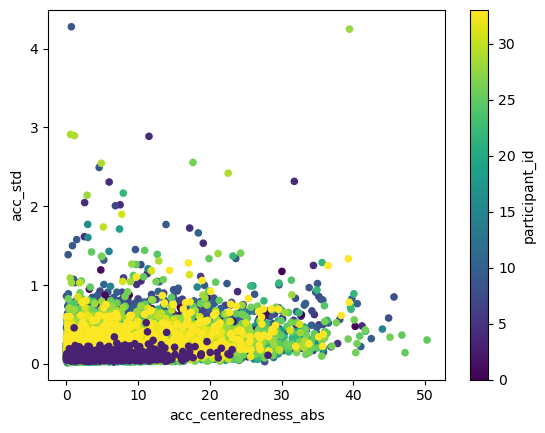

In [268]:
filtered_samples.plot.scatter(x="acc_centeredness_abs", y="acc_std", c="participant_id", colormap="viridis")

In [187]:
X = []
Y = []
for sample in samples:
    x = np.stack([sample["acc"], sample["gyro"]], axis=-1)
    y = (sample["label"], sample["participant"], sample["session"])
    X.append(x)
    Y.append(y)

In [196]:
n_clusters = 3

#kmeans = KernelKMeans(n_clusters=3, kernel="gak", n_init=100, random_state=0)
#kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_init=1, random_state=0)
kmeans = KShape(n_clusters=3, n_init=1, random_state=0)
clusters = kmeans.fit_predict(X)


KeyboardInterrupt: 

In [240]:
sample_df["acc_centeredness"].median()

-5220074879595.83